## **Importing the libraries**

In [98]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## **Getting the sound files**

In [2]:
# Connect to my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Go to the image_classification folder in Google Drive
%cd /content/drive/My Drive/speech_emotion_recognition/data

# Set the path to the image_classification folder
path = "/content/drive/My Drive/speech_emotion_recognition/data"

/content/drive/My Drive/speech_emotion_recognition/data


In [4]:
files = glob.glob("*.wav")

## **Keeping track of the recorded emotions**

In [5]:
# Create a dictionary that keeps track of the emotion id's and their corresponding emotions
emotions = {
    '01' : 'neutral',
    '02' : 'calm', 
    '03' : 'happy',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disgust',
    '08' : 'surprised'
}

In [6]:
# Count how many files fall under each type of emotion
# Create a dictionary to keep track of the counts
emotion_count = dict(Counter([filename.split('-')[2] for filename in files]))
emotion_count = {emotions[id]:val for id, val in emotion_count.items()}

emotion_count

{'angry': 376,
 'calm': 376,
 'disgust': 192,
 'fearful': 376,
 'happy': 376,
 'neutral': 188,
 'sad': 376,
 'surprised': 192}

In [42]:
# Create a dictionary to store the emotions in reverse (keys and values are swapped)
emotions_reversed = {val:id for id, val in emotions.items()}

# Create a list to store the names of emotions
emotions_names = list(emotions.values())

## **Analyzing one sound file**

In [7]:
# Take one of the sound file and analyze it
voice_file = files[200]

voice_file

'03-02-06-01-01-02-16.wav'

In [8]:
# Get the data and sample rate of the voice file using soundfile
sound = soundfile.SoundFile(voice_file)

data = sound.read(dtype = "float32")
sample_rate = sound.samplerate

In [9]:
# We can play the sound file using IPython
ipd.Audio(voice_file)

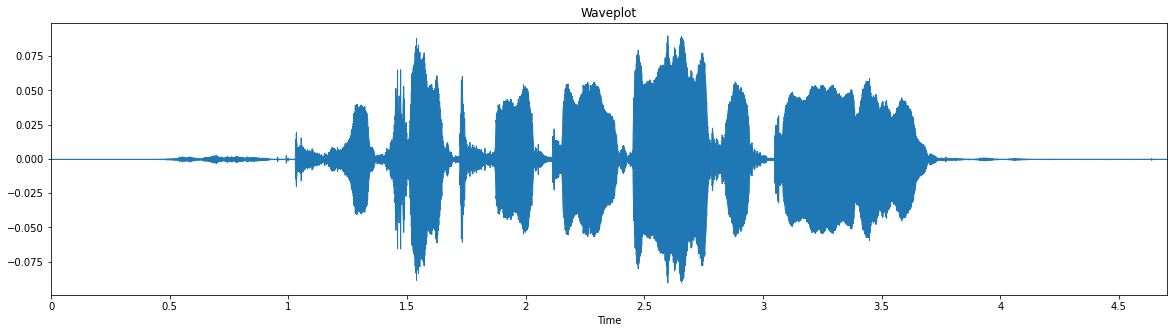

In [10]:
# Plot the waveplot of the voice file
plt.figure(figsize = (20, 5))
plt.title("Waveplot")
librosa.display.waveplot(data, sr = sample_rate)

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


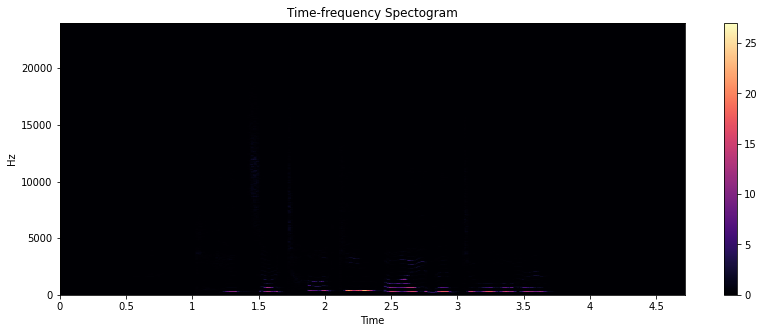

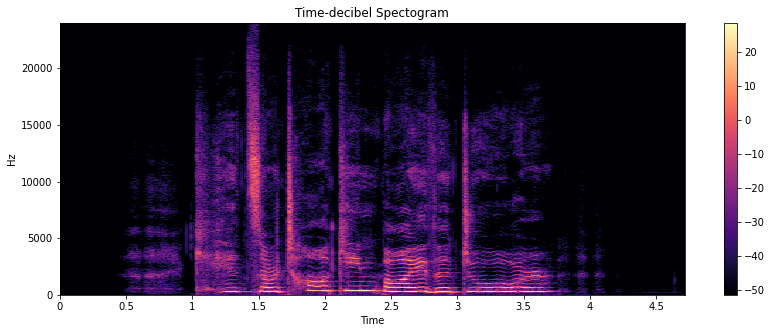

In [11]:
# Plot the spectogram of the voice file
# Change the data to the time-frequency domain
data_time_freq = librosa.stft(data)
plt.figure(figsize = (14, 5))
plt.title("Time-frequency Spectogram")
librosa.display.specshow(data_time_freq, sr = sample_rate, x_axis = "time", y_axis = "hz")
plt.colorbar()

# Change the data to the time-decibel domain 
data_time_db = librosa.amplitude_to_db(abs(data_time_freq))
plt.figure(figsize = (14, 5))
plt.title("Time-decibel Spectogram")
librosa.display.specshow(data_time_db, sr = sample_rate, x_axis = "time", y_axis = "hz")
plt.colorbar()

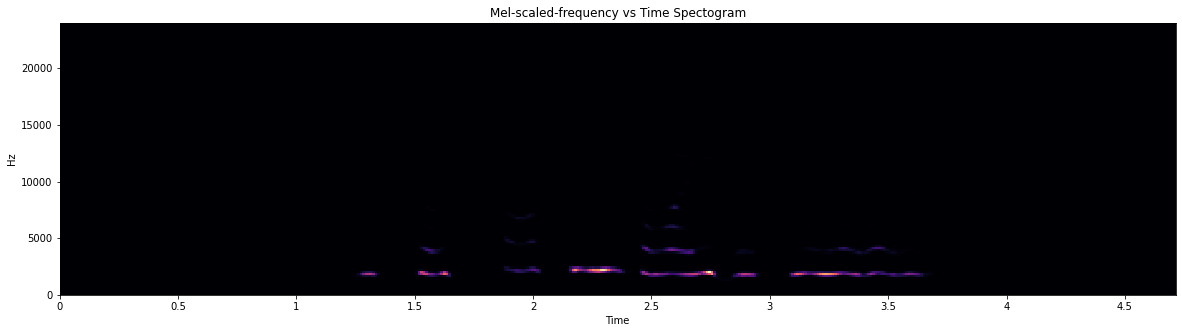

In [35]:
# Plot the mel-spectogram
data_mel = librosa.feature.melspectrogram(data, sr = sample_rate)
plt.figure(figsize = (20, 5))
plt.title("Mel-scaled-frequency vs Time Spectogram")
librosa.display.specshow(data_mel, sr = sample_rate, x_axis = "time", y_axis = "hz")

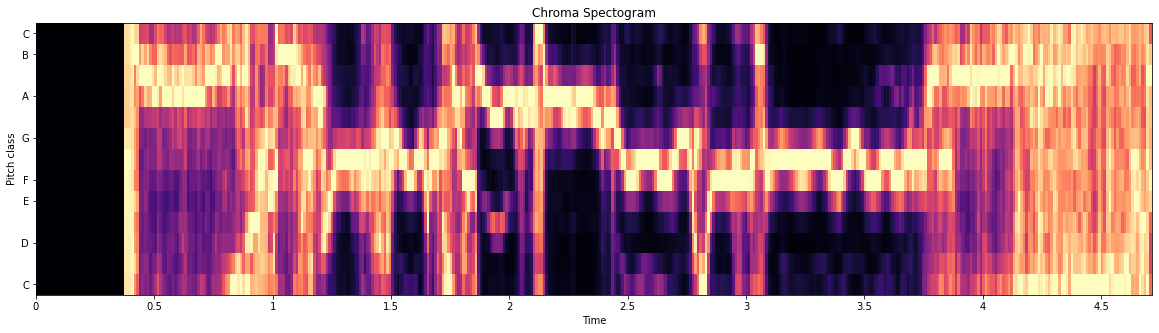

In [38]:
# Plot the chroma spectogram
chroma = librosa.feature.chroma_stft(S = np.abs(data_time_freq), sr = sample_rate, n_chroma = 13)
plt.figure(figsize = (20, 5))
plt.title("Chroma Spectogram")
librosa.display.specshow(chroma, sr = sample_rate, x_axis = "time", y_axis = "chroma")

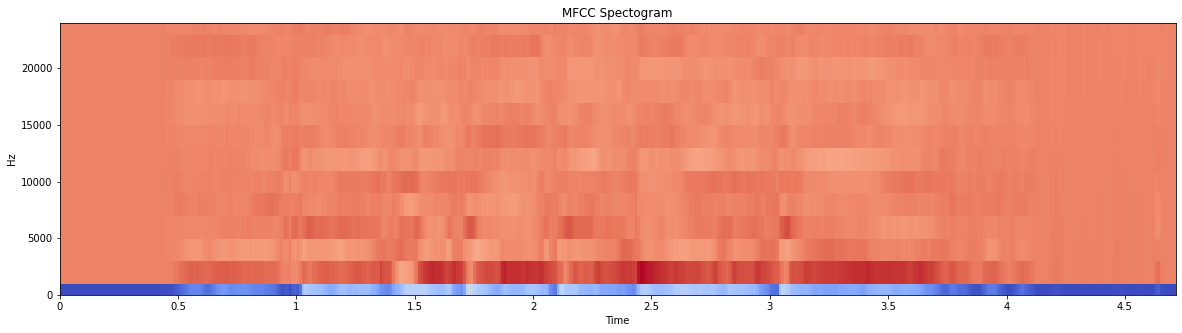

In [32]:
# Plot the MFCC
mfcc = librosa.feature.mfcc(data, sr = sample_rate, n_mfcc = 13)
plt.figure(figsize = (20, 5))
plt.title("MFCC Spectogram")
librosa.display.specshow(mfcc, sr = sample_rate, x_axis = "time", y_axis = "hz")

In [15]:
data.shape

(225826,)

The number of zero crossings in between data[110000:110200] is:  3


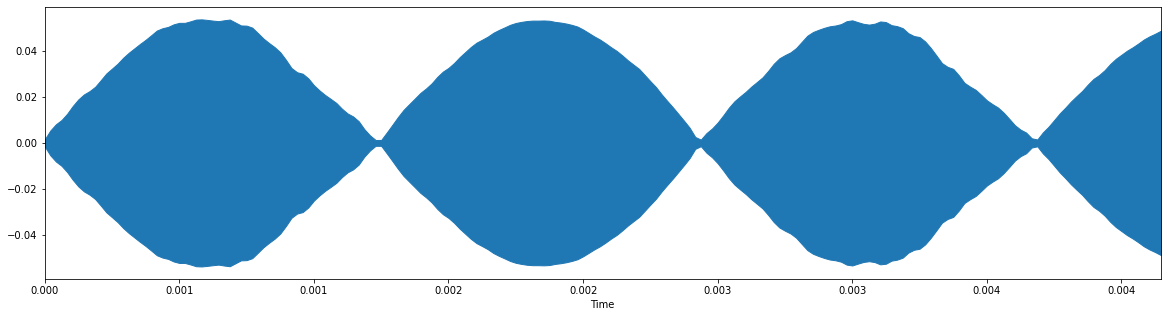

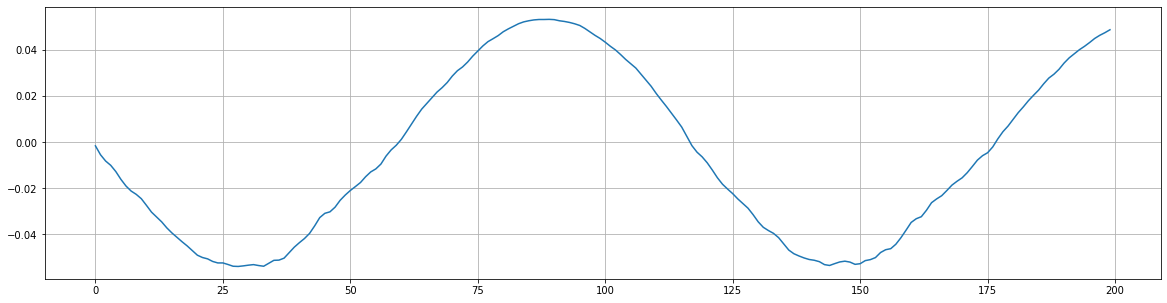

In [17]:
# Plot the waveplot of the zero crossings
plt.figure(figsize = (20, 5))
librosa.display.waveplot(data[110000:110200], sr = sample_rate)

# Show the zero crossings as a line plot
plt.figure(figsize = (20, 5))
plt.plot(data[110000:110200])
plt.grid()

zero_crossing_counts = librosa.zero_crossings(data[110000:110200], pad = False)
print("The number of zero crossings in between data[110000:110200] is: ", sum(zero_crossing_counts))

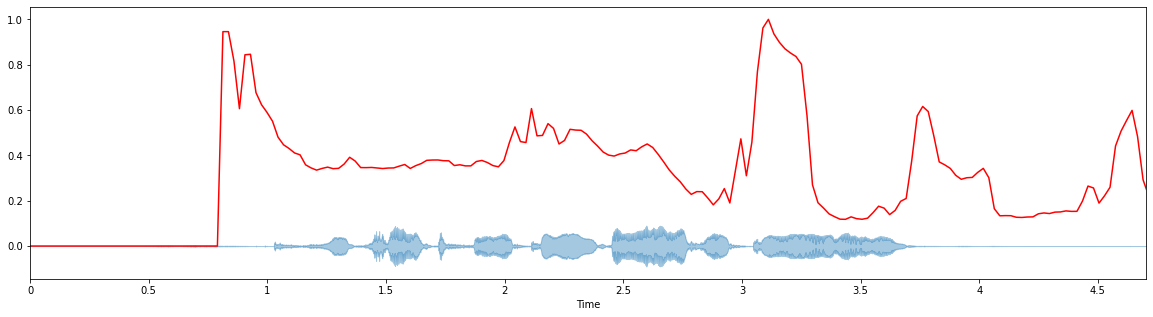

In [66]:
# Plot the spectral centroid of the sound
spectral_centroids = librosa.feature.spectral_centroid(data, sr = sample_rate)[0]

# Compute the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

plt.figure(figsize = (20, 5))
librosa.display.waveplot(data, sr = sample_rate, alpha = 0.4)
plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_centroids, axis = 0), color='r')

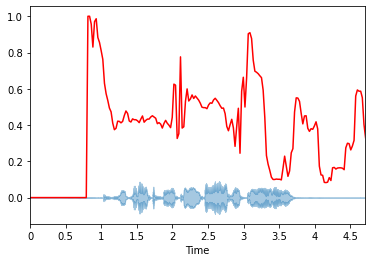

In [67]:
# Plot the spectral rolloff of the sound
spectral_rolloff = librosa.feature.spectral_rolloff(data, sr = sample_rate)[0]

librosa.display.waveplot(data, sr = sample_rate, alpha = 0.4)
plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_rolloff, axis = 0), color='r')

## **Analyzing all sound files**

In [118]:
# Create a function that extracts the features of a given voice file
def extract_features(voice_file):
  sound_file = soundfile.SoundFile(voice_file)
  sound_data = sound_file.read(dtype = "float32")
  sound_samplerate = sound_file.samplerate
  data_stft = librosa.stft(sound_data)

  # Create an empty array to store the features
  features = np.array([])

  # Get the mel features (row by row mean)
  mel = librosa.feature.melspectrogram(sound_data, sr = sound_samplerate)
  mel_mean = np.mean(mel, axis = 1)
  features = np.hstack((features, mel_mean))

  # Get the chroma features (row by row mean)
  chroma = librosa.feature.chroma_stft(S = np.abs(data_stft), sr = sound_samplerate, n_chroma = 24)
  chroma_mean = np.mean(chroma, axis = 1)
  features = np.hstack((features, chroma_mean))

  # Get the mfcc features (row by row mean)
  mfcc = librosa.feature.mfcc(sound_data, sr = sound_samplerate, n_mfcc = 40)
  mfcc_mean = np.mean(mfcc, axis = 1)
  features = np.hstack((features, mfcc_mean))

  # Get the zero crossings features (sum of zero crossings)
  zero_crossings_sum = sum(librosa.zero_crossings(sound_data, pad = False))
  features = np.hstack((features, zero_crossings_sum))

  # Get the spectral centroid features (mean)
  #spectral_centroids = librosa.feature.spectral_centroid(sound_data, sr = sound_samplerate)[0]
  #spectral_centroids_mean = np.mean(spectral_centroids)
  #features = np.hstack((features, spectral_centroids_mean))

  # Get the spectral rolloff features (mean)
  #spectral_rolloff = librosa.feature.spectral_rolloff(sound_data, sr = sound_samplerate)[0]
  #spectral_rolloff__mean = np.mean(spectral_rolloff)
  #features = np.hstack((features, spectral_rolloff__mean))

  return features

## **Loading all sound files**

In [110]:
# Create a function to load all sound files and form a list of feature-target pairs
def load_data():
  x = []
  y = []

  for f in files:
    try:
      emotion = emotions[f.split("-")[2]]
      features = extract_features(f)
      x.append(features)
      y.append(emotion)
    except Exception as e:
      print(e, f)

  return [np.array(x), y]

In [119]:
x_data, y_data = load_data()

Invalid shape for monophonic audio: ndim=2, shape=(166566, 2) 03-01-03-01-02-01-20.wav
Invalid shape for monophonic audio: ndim=2, shape=(209809, 2) 03-01-06-01-01-02-20.wav
Invalid shape for monophonic audio: ndim=2, shape=(229029, 2) 03-02-01-01-01-01-24.wav
Invalid shape for monophonic audio: ndim=2, shape=(172972, 2) 03-01-02-01-01-02-01.wav
Invalid shape for monophonic audio: ndim=2, shape=(156956, 2) 03-01-08-01-02-02-01.wav
Invalid shape for monophonic audio: ndim=2, shape=(203403, 2) 03-01-02-01-02-02-05.wav


## **Splitting the dataset**

In [120]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 0)

# Subtract one since indices start from 0
y_train = to_categorical([int(emotions_reversed[x]) - 1 for x in y_train])
y_test = to_categorical([int(emotions_reversed[x]) - 1 for x in y_test])

In [121]:
# Look at the number of columns in x_train to determine the number of neurons in the first layer
x_train.shape[1]

193

## **Training the model**

In [139]:
# Create the model
np.random.seed(1) # repr

earlystop = EarlyStopping(monitor = "accuracy", patience = 100)

model = Sequential()
model.add(Dense(120, input_shape = (x_train.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(len(emotions_names), activation='softmax'))

# Configure the model and start training
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [140]:
# Fit the model to the training set
history = model.fit(x_train, y_train, epochs = 1500, batch_size = 64, verbose=1, shuffle=True, validation_split=0.2, callbacks=[earlystop], use_multiprocessing=True, workers=3)

Epoch 1/1500
25/25 [==============================] - 1s 14ms/step - loss: 74.1590 - accuracy: 0.1208 - val_loss: 17.4071 - val_accuracy: 0.1046
Epoch 2/1500
25/25 [==============================] - 0s 5ms/step - loss: 9.4008 - accuracy: 0.1496 - val_loss: 5.8085 - val_accuracy: 0.1148
Epoch 3/1500
25/25 [==============================] - 0s 5ms/step - loss: 4.3090 - accuracy: 0.1643 - val_loss: 3.3164 - val_accuracy: 0.1556
Epoch 4/1500
25/25 [==============================] - 0s 5ms/step - loss: 2.7308 - accuracy: 0.1886 - val_loss: 2.4938 - val_accuracy: 0.1760
Epoch 5/1500
25/25 [==============================] - 0s 5ms/step - loss: 2.8148 - accuracy: 0.1439 - val_loss: 2.6116 - val_accuracy: 0.1378
Epoch 6/1500
25/25 [==============================] - 0s 5ms/step - loss: 2.5060 - accuracy: 0.1579 - val_loss: 2.0457 - val_accuracy: 0.2219
Epoch 7/1500
25/25 [==============================] - 0s 5ms/step - loss: 2.2186 - accuracy: 0.1841 - val_loss: 2.5065 - val_accuracy: 0.1633
Epo

## **Testing using the trained model**

In [141]:
test_results = model.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - accuracy: {test_results[1]}%')

y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

16/16 [==============================] - 0s 3ms/step - loss: 3.4795 - accuracy: 0.5694
Test results - Loss: 3.479473829269409 - accuracy: 0.5693877339363098%
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        28
           1       0.66      0.74      0.70        74
           2       0.57      0.44      0.50        91
           3       0.56      0.57      0.56        69
           4       0.70      0.63      0.67        79
           5       0.49      0.56      0.52        79
           6       0.47      0.44      0.45        34
           7       0.40      0.47      0.44        36

    accuracy                           0.57       490
   macro avg       0.56      0.57      0.56       490
weighted avg       0.57      0.57      0.57       490

[[19  2  1  1  1  1  0  3]
 [ 5 55  5  6  0  0  2  1]
 [ 3  9 40  3 11 14  2  9]
 [ 2  7  2 39  1 15  0  3]
 [ 1  0  3  2 50 13  7  3]
 [ 1  2 10 13  2 44  4  3]
 [ 1  4  1  2  5  3 15  3]
 [

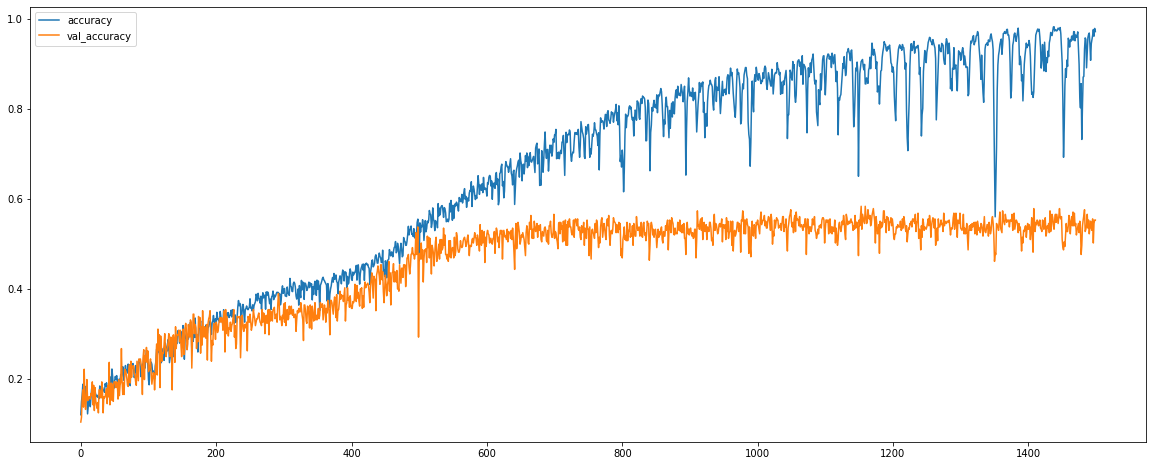

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])